# Problem Set 2

## Introduction to the assignment

For this assignment, you will be using data from the [Progresa program](http://en.wikipedia.org/wiki/Oportunidades), a government social assistance program in Mexico. This program, as well as the details of its impact, are described in the paper "[School subsidies for the poor: evaluating the Mexican Progresa poverty program](http://www.sciencedirect.com/science/article/pii/S0304387803001858)", by Paul Shultz (available on bCourses). Please familiarize yourself with the PROGRESA program before beginning this problem set, so you have a rough sense of where the data come from and how they were generated. If you just proceed into the problem set without understanding Progresa or the data, it will be very difficult!

The goal of this problem set is to implement some of the basic econometric techniques that you are learning in class to measure the impact of Progresa on secondary school enrollment rates. The timeline of the program was:

 * Baseline survey conducted in 1997
 * Intervention begins in 1998, "Wave 1" of surveys conducted in 1998
 * "Wave 2" of surveys conducted in 1999
 * Evaluation ends in 2000, at which point the control villages were treated. 
 
When you are ready, download the progresa_sample.csv data from bCourses. The data are actual data collected to evaluate the impact of the Progresa program.  In this file, each row corresponds to an observation taken for a given child for a given year. There are two years of data (1997 and 1998), and just under 40,000 children who are surveyed in each year. For each child-year observation, the following variables are collected:

| Variable name | Description|
|------|------|
|year	  |year in which data is collected
|sex	  |male = 1|
|indig	  |indigenous = 1|
|dist_sec |nearest distance to a secondary school|
|sc	      |enrolled in school in year of survey|
|grc      |grade enrolled|
|fam_n    |family size|
|min_dist |	min distance to an urban center|
|dist_cap |	min distance to the capital|
|poor     |	poor = 1|
|progresa |treatment =1|
|hohedu	  |years of schooling of head of household|
|hohwag	  |monthly wages of head of household|
|welfare_index|	welfare index used to classify poor|
|hohsex	|gender of head of household (male=1)|
|hohage	|age of head of household|
|age	|years old|
|folnum	|individual id|
|village|	village id|
|sc97	|schooling in 1997|
|grc97  |grade enrolled in 1997

## Notes on Program, Paper & Dataset

### Program
* Gov't social assistance program in Mexico.
* Founded in 2002 - based on program created in 1997
* Provides cash payments to families in exchange for: regular school attendance, health clinic visits and nutrition support
* Conditional Cash Transfer (CCT)

### Paper

* Area: Rural mexico
* Subject: Poor mothers
* IV: education grants provided by the 'Progresa' program
* DV: enrollment rate of children
* Design: poor children in communities 'randomly' selected are compared to those who reside in 'control' communities
    - Probit models used to estimate probability child is enrolled, controlling for additional characteristics of the child, family, community and taking into account attrition
    - 

### Dataset
* We'll look at the columns more specifically down below


---

## Part 1: Descriptive analysis

In [231]:
### Environment

# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline  

# The packages you'll need for regression models
import statsmodels.api as sm
import statsmodels.formula.api as smf

### Read in Data
df = pd.read_csv('progresa_sample.csv')


### 1.1	Summary Statistics

Present summary statistics (mean, median and standard deviation) for all of the demographic variables in the dataset (i.e., everything except year, folnum, village). Present these in a single table alphabetized by variable name. Do NOT simply expect the grader to scroll through your output!

*Note:* For this and subsequent problems, you will need to be careful in how you deal with missing (NULL) values. You should not blindly drop rows and columns where any data field is missing.  For instance, in calculating the average `hohwag`, you should average the `hohwag` values from all households that report a value (even if the household does not have a recorded `age` value, for example). 


First things we'll need to separate the columns by type. For the purposes of further analysis, I see three main types:
* `ID columns`: non-demographic, meta-data columns for identification. Should not be included in analysis themselves, and particularly don't lend themselves well to summary stats
* `categorical/binary columns`: generally 0 or 1. Do not lend themselves to `mean`, `median` or `std.Dev` for obvious reasons. But can run other descriptive stats
* `numeric/metric columns`: these are the one's we'll want to actually look at

In [232]:
# Let's look at a basic column summary
display(df.head(5))

# dtype can rule out some, but can also mislead though since a lot of the categorical cols are binary (0,1)
display(df.dtypes)

# use describe for a rough overview
(df
 .describe()
 .transpose()
 .apply(round, 0)
)



,year,sex,indig,dist_sec,sc,grc,fam_n,min_dist,dist_cap,poor,...,hohedu,hohwag,welfare_index,hohsex,hohage,age,village,folnum,grc97,sc97
0,97,0.0,0.0,4.473,1.0,7.0,7,21.168384,21.168384,pobre,...,6,0.0,583.0,1.0,35.0,13,163,1,7,1.0
1,98,0.0,0.0,4.473,1.0,8.0,7,21.168384,21.168384,pobre,...,6,0.0,583.0,1.0,35.0,14,163,1,7,1.0
2,97,1.0,0.0,4.473,1.0,6.0,7,21.168384,21.168384,pobre,...,6,0.0,583.0,1.0,35.0,12,163,2,6,1.0
3,98,1.0,0.0,4.473,1.0,7.0,7,21.168384,21.168384,pobre,...,6,0.0,583.0,1.0,35.0,13,163,2,6,1.0
4,97,0.0,0.0,4.473,1.0,2.0,7,21.168384,21.168384,pobre,...,6,0.0,583.0,1.0,35.0,8,163,3,2,1.0


year               int64
sex              float64
indig            float64
dist_sec         float64
sc               float64
grc              float64
fam_n              int64
min_dist         float64
dist_cap         float64
poor              object
progresa          object
hohedu             int64
hohwag           float64
welfare_index    float64
hohsex           float64
hohage           float64
age                int64
village            int64
folnum             int64
grc97              int64
sc97             float64
dtype: object

,count,mean,std,min,25%,50%,75%,max
year,77250.0,98.0,1.0,97.0,97.0,98.0,98.0,98.0
sex,77226.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0
indig,76950.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
dist_sec,77250.0,2.0,2.0,0.0,1.0,2.0,4.0,15.0
sc,68797.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0
grc,70701.0,4.0,2.0,0.0,2.0,4.0,6.0,14.0
fam_n,77250.0,7.0,2.0,1.0,6.0,7.0,9.0,24.0
min_dist,77250.0,103.0,42.0,9.0,71.0,111.0,138.0,170.0
dist_cap,77250.0,148.0,76.0,9.0,92.0,132.0,184.0,360.0
hohedu,77250.0,3.0,3.0,0.0,0.0,2.0,4.0,20.0


In [233]:
# Other investigations
df['sc'].value_counts()
df['sc97'].value_counts()
df['grc97'].value_counts()
df['hohsex'].value_counts()

df['hohedu'].value_counts()
df['hohage'].value_counts()
df['age'].value_counts()


age
8     7329
7     7327
11    7305
12    7209
10    7169
13    7104
9     7090
14    6839
15    6755
16    6413
6     3666
17    3044
Name: count, dtype: int64

#### Column Categories

**ID**: 
* `year`
* `folnum` - [UID]
* `village`

**Categorical** (binary unless o/w noted):
* `sex`
* `indig`
* `sc`
* `poor` (is textual in raw form)
* `progresa` (is textual in raw form)
* `sc97`
* `hohsex`

**Numeric**:
* `dist_sec` (pure continuous)
* `grc` (categorical but sequential)
* `fam_n` (integer)
* `min_dist` (pure continuous)
* `dist_cap` (pure continuous)
* `hohedu` (integer)
* `hohwag` (pure continuous)
* `welfare_index` (continuous metric)
* `hohage` (integer)
* `age` (integer)
* `grc97` (categorical but sequential)


In [234]:
id_cols = ['year','folnum','village'] # skip
cat_cols = ['sex','indig','sc','poor','progresa','sc97','hohsex'] # do other things
metric_cols = ['dist_sec','grc','fam_n','min_dist','dist_cap','hohedu','hohwag','welfare_index','hohage','age','grc97'] # standard summary stats

# Check we have all the cols - ✅
set(df.columns.to_list()) - set(id_cols + cat_cols + metric_cols)
set(id_cols + cat_cols + metric_cols) - set(df.columns.to_list())

# Let's start with Metric cols

## first look for nulls to be safe
cols_w_nulls = (
    df[metric_cols]
    .isnull()
    .any()
) # all cols that contain any nulls

df[metric_cols][cols_w_nulls[~cols_w_nulls].index.to_list()] # select all cols without nulls - not sure it actually matters here since we want to ignore them

# Define summary funcs
metric_summary_funcs = [np.nanmean, np.nanmedian, np.nanstd]

metric_summaries = (
    df[metric_cols]
    .apply(metric_summary_funcs)
    .transpose()
    .round(2)
    .rename(columns=lambda x: x.replace('nan', ''))
)
display(metric_summaries)

,mean,median,std
dist_sec,2.42,2.28,2.23
grc,3.96,4.00,2.50
fam_n,7.22,7.00,2.35
min_dist,103.45,111.23,42.09
dist_cap,147.67,132.00,76.06
hohedu,2.77,2.00,2.66
hohwag,586.99,500.00,788.13
welfare_index,690.35,685.00,139.49
hohage,44.44,43.00,11.62
age,11.37,11.00,3.17


In [235]:
# Now for the cartegorical ones
df[cat_cols].head()

## We'll need to transform the two text cols
display(df['poor'].value_counts())
### `poor`
poor_dict = {'pobre': 1, 'no pobre': 0}
df['poor'] = [poor_dict[x] for x in df['poor']]

# ### `progresa`
display(df['progresa'].value_counts())
progresa_dict = {'basal': 1, '0': 0} # note: this doesn't really matter?
df['progresa'] = [progresa_dict[x] for x in df['progresa']]

display(df[['poor', 'progresa']].value_counts())

# now for the actual summary funcs - let's just go with mean??

# first check nulls?

df[cat_cols]
cat_summaries = pd.DataFrame({
    'mean': df[cat_cols].apply(np.nanmean),
    'median': np.NaN, # just make this blank cause it doesn't make sense
    'std': df[cat_cols].apply(np.nanstd),
})
cat_summaries

poor
pobre       65392
no pobre    11858
Name: count, dtype: int64

progresa
basal    47560
0        29690
Name: count, dtype: int64

poor  progresa
1     1           40444
      0           24948
0     1            7116
      0            4742
Name: count, dtype: int64

,mean,median,std
sex,0.512211,NaN,0.499851
indig,0.298324,NaN,0.457522
sc,0.819818,NaN,0.384339
poor,0.846498,NaN,0.360470
progresa,0.615663,NaN,0.486438
sc97,0.813922,NaN,0.389169
hohsex,0.925185,NaN,0.263093


#### 1.1 Answer

In [236]:
# Combine and output 1.1 answer
pd.concat(
    [metric_summaries,
    cat_summaries]
).sort_index()

,mean,median,std
age,11.370000,11.00,3.170000
dist_cap,147.670000,132.00,76.060000
dist_sec,2.420000,2.28,2.230000
fam_n,7.220000,7.00,2.350000
grc,3.960000,4.00,2.500000
grc97,3.710000,4.00,2.570000
hohage,44.440000,43.00,11.620000
hohedu,2.770000,2.00,2.660000
hohsex,0.925185,NaN,0.263093
hohwag,586.990000,500.00,788.130000


### 1.2 Differences at baseline?

Are the baseline (1997) demographic characteristics **for the poor**  different in treatment and control villages?  Present your results in a single table with the following columns and 14 (or so) rows (alphabetized by variable name):


| Variable name | Average value (Treatment villages) | Average value (Control villages) | Difference (Treat - Control) | p-value |
|------|------|------|------|------|
|Male|?|?|?|?|

 *Hint:* Use a T-Test to determine whether there is a statistically significant difference in the average values of each of the variables in the dataset. Focus only on the data from 1997 from poor households (i.e., poor=='pobre').



In [237]:
# your code here
# First lets use a basic group_by to see if we can visulize any differences
(
    df
    .query('poor == 1')
    .query('year == 97')
    .groupby('progresa')
    .agg('mean')
    .transpose()
    .apply(round, 1)
    .rename(columns={0: 'Control', 1: 'Treat'})
    .pipe(display)
)

# Now the t-test
## let's calculate by hand since we already ran the mean/std above and it'll be good practice for some table-operations
t_summary_funcs = [np.nanmean, np.nanstd, np.nanvar, lambda x: sum(~np.isnan(x))] # weird behavior around groupby summary stats?
t_summary_funcs = ['mean', 'std', 'var', lambda x: sum(~np.isnan(x))] # so use this instead

# Get classes
df97 = df[(df['year'] == 97) & (df['poor'] == 1)]
df97_treat = df97[df97['progresa'] == 1]
df97_control = df97[df97['progresa'] == 0]

# now map over the columns and calculate columns
df97_t_summary_df = (
    df97[metric_cols + cat_cols]
    .query('poor == 1') # poor only
    .groupby('progresa') # group by tc_var
    .agg(t_summary_funcs) # aggregate across all summary funcs
    .rename(level = 1, columns={'mean':'m','<lambda_0>': 'n'}) # rename to match the t-stat formula
    .stack(0) 
    .unstack(0) # swap index axes
    .rename(level = 1, columns={0: '0', 1: '1'}) # set to char
    .pipe(lambda s: s.set_axis(s.columns.map('_'.join), axis=1)) # collapse the two-level col-headers into 1
    .drop(['std_0','std_1'], axis=1) # drop stddev cause its unnecessary
)
display(df97_t_summary_df)


progresa,Control,Treat
year,97.0,97.0
sex,1.0,1.0
indig,0.0,0.0
dist_sec,3.0,2.0
sc,1.0,1.0
grc,4.0,4.0
fam_n,7.0,7.0
min_dist,103.0,107.0
dist_cap,154.0,151.0
poor,1.0,1.0


,m_0,m_1,var_0,var_1,n_0,n_1
age,10.742023,10.716991,9.604412,9.640836,12474,20222
dist_cap,153.769730,150.829074,6828.637075,5462.516186,12474,20222
dist_sec,2.507662,2.453122,6.201619,4.584901,12474,20222
fam_n,7.302469,7.281327,5.583082,5.396396,12474,20222
grc,3.543050,3.531599,6.372595,6.280664,12474,20222
grc97,3.543050,3.531599,6.372595,6.280664,12474,20222
hohage,44.276918,43.648828,140.246755,129.199816,12473,20218
hohedu,2.590348,2.663139,6.050403,6.502512,12474,20222
hohsex,0.922947,0.924656,0.071121,0.069671,12472,20214
hohwag,573.163558,544.339544,497928.940651,494928.976888,12474,20222


So now we have this dataframe with all the data we need. We can now apply the t_test formula found [here](https://www.peggykern.org/uploads/5/6/6/7/56678211/ttestformulas.pdf), copied below:

<img src="Images/t_test_formula.png" width=800 height=200 />

In [238]:
# Now we can caclulate the t-stat by hand
df97_t_summary_df['S_pooled'] = np.sqrt((df97_t_summary_df['var_0']/df97_t_summary_df['n_0']) + (df97_t_summary_df['var_1']/df97_t_summary_df['n_1']))
df97_t_summary_df['t_stat'] = (df97_t_summary_df['m_1'] - df97_t_summary_df['m_0'])/df97_t_summary_df['S_pooled']
df97_t_summary_df['df'] = df97_t_summary_df['n_0'] + df97_t_summary_df['n_1'] - 2

from scipy.stats import t # get the p-val
df97_t_summary_df['p_val'] = (1 - t.cdf(np.abs(df97_t_summary_df['t_stat']), df97_t_summary_df['df'])) * 2

# set arbitrary alpha at .05
alpha = .05
df97_t_summary_df['p_val'] < alpha
df97_t_summary_df['signf'] = ['***' if p < .001 else '**' if p < .01 else '*' if p < .05 else '' for p in df97_t_summary_df['p_val']]

# return the resulting table
#display(df97_t_summary_df[['m_0','m_1','t_stat','p_val','signf']])

(
    df97_t_summary_df[['m_0','m_1','t_stat','p_val','signf']]
    .assign(t_stat_abs = abs(df97_t_summary_df['t_stat']))
    .dropna() # remove the stat for 'poor'
    .style.background_gradient(axis=0, subset = 't_stat_abs')
    .pipe(display)
)

df97_t_summary_df

,m_0,m_1,t_stat,p_val,signf,t_stat_abs
age,10.742023,10.716991,-0.708947,0.478362,,0.708947
dist_cap,153.769730,150.829074,-3.252260,0.001146,**,3.252260
dist_sec,2.507662,2.453122,-2.027106,0.042660,*,2.027106
fam_n,7.302469,7.281327,-0.790974,0.428965,,0.790974
grc,3.543050,3.531599,-0.399507,0.689522,,0.399507
grc97,3.543050,3.531599,-0.399507,0.689522,,0.399507
hohage,44.276918,43.648828,-4.729794,0.000002,***,4.729794
hohedu,2.590348,2.663139,2.563012,0.010381,*,2.563012
hohsex,0.922947,0.924656,0.564931,0.572124,,0.564931
hohwag,573.163558,544.339544,-3.592015,0.000329,***,3.592015


,m_0,m_1,var_0,var_1,n_0,n_1,S_pooled,t_stat,df,p_val,signf
age,10.742023,10.716991,9.604412,9.640836,12474,20222,0.035309,-0.708947,32694,4.783621e-01,
dist_cap,153.769730,150.829074,6828.637075,5462.516186,12474,20222,0.904189,-3.252260,32694,1.146073e-03,**
dist_sec,2.507662,2.453122,6.201619,4.584901,12474,20222,0.026905,-2.027106,32694,4.265962e-02,*
fam_n,7.302469,7.281327,5.583082,5.396396,12474,20222,0.026729,-0.790974,32694,4.289652e-01,
grc,3.543050,3.531599,6.372595,6.280664,12474,20222,0.028661,-0.399507,32694,6.895222e-01,
grc97,3.543050,3.531599,6.372595,6.280664,12474,20222,0.028661,-0.399507,32694,6.895222e-01,
hohage,44.276918,43.648828,140.246755,129.199816,12473,20218,0.132794,-4.729794,32689,2.256850e-06,***
hohedu,2.590348,2.663139,6.050403,6.502512,12474,20222,0.028401,2.563012,32694,1.038128e-02,*
hohsex,0.922947,0.924656,0.071121,0.069671,12472,20214,0.003025,0.564931,32684,5.721243e-01,
hohwag,573.163558,544.339544,497928.940651,494928.976888,12474,20222,8.024470,-3.592015,32694,3.286125e-04,***


In [239]:
# And redo it using the actual formula since we know it, but using a for loop --> verdict: it's close enough to keep my manual one

# from above we have t/c dfs already filtered to only 97 and only poor villages
from scipy import stats
df97_treat

cols = []
t_stats = []
p_vals = []
for col in metric_cols + cat_cols:
    t_stat, p_val = stats.ttest_ind(df97_treat[col].dropna(), df97_control[col].dropna())

    cols.append(col)
    t_stats.append(t_stat)
    p_vals.append(p_val)

temp_t_df = pd.DataFrame({'col': cols, 't_stat': t_stats, 'p_val': p_vals})
# assign signif markers
temp_t_df['signf'] = ['***' if p < .001 else '**' if p < .01 else '*' if p < .05 else '' for p in temp_t_df['p_val']]
# Display tables


# # Display Tables next to each other
from IPython.core.display import display, HTML
def display_side_by_side(dfs:list, captions:list):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    combined = dict(zip(captions, dfs))
    for caption, df in combined.items():
        if type(df) == 'pandas.io.formats.style.Styler':
            print('is styler')
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += "\xa0\xa0\xa0"
    display(HTML(output))

df_t_comp_html = (
    temp_t_df
    .set_index('col')
    .sort_index()
    #.style
        #.background_gradient(axis=0, subset = 'p_val', cmap='Blues_r') # Add conditional formatting
        #.set_table_attributes("style='display:inline") # make them sit next to each other
        #.set_caption('t-Score calculated using `scipy.stats.ttest_ind`') # A
)

df_t_man_styler = (
    df97_t_summary_df[['t_stat','p_val','signf']].
    sort_index()
    #.style 
        #.background_gradient(axis=0, subset = 'p_val', cmap='Blues_r')
        #.set_table_attributes("style='display:inline") # make them sit next to each other
        #.set_caption('t-Score calculated manually')
)

display_side_by_side([df_t_comp_html, df_t_man_styler], captions = ['t-Score calculated using `scipy.stats.ttest_ind`', 't-Score calculated manually'])


# #type(df_t_man_styler.style.background_gradient(axis=0, subset = 'p_val', cmap='Blues_r'))

/Users/jon/anaconda3/envs/aml/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
/var/folders/t8/dm9l8xy95mv0d_75b2m8r5nw0000gn/T/ipykernel_11291/2648845426.py:24: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


,t_stat,p_val,signf
col,,,
age,-0.708630,0.478559,
dist_cap,-3.339081,0.000842,***
dist_sec,-2.100433,0.035698,*
fam_n,-0.794167,0.427104,
grc,-0.400196,0.689015,
grc97,-0.400196,0.689015,
hohage,-4.775962,0.000002,***
hohedu,2.541229,0.011051,*
hohsex,0.566312,0.571186,


### 1.3 Interpretation

* A: Are there statistically significant differences between treatment and control villages at baseline? 
* B: Why does it matter if there are differences at baseline?
* C: What does this imply about how to measure the impact of the treatment?

*Discuss your results here*

A: In the above table, we can see that there are quite a few columns where the difference between the samples may be statistically significant. Most ntoably, there appear to be large and significant differences in `dist_cap`, `hohage`, `hohwag` and `min_dist`. `welfare_index` also shows some significant differences but given that it is itself an index, and is less significant, it would be worth exploring further.

B: It is important to know how your treatment and control datasets differ on important measures because in attempting to measure the impact of the treatment in a generalizable way, it is important to try to separate which effects are from differences in the data itself or reactions to it, rather than from the effect of the treatment.

C: we'll have to use difference of difference because otherwise any effect of the treatment could be drowned out, obscured or counteracted by the endogenous differences between the control and treatment groups that we see here.

### 1.4 Graphical exploration, part 1

Visualize the distribution of village enrollment rates **among poor households in treated villages**, before and after treatment. Specifically, for each village, calculate the average rate of enrollment of poor households in treated villages in 1997, then compute the average rate of enrollment of poor households in treated villages in 1998. Create two separate histograms showing the distribution of these average enrollments rates, one histogram for 1997 and one histogram for 1998. On each histogram, draw a vertical line that intersects the x-axis at the average value (across all households). Does there appear to be a difference? Is this difference statistically significant?

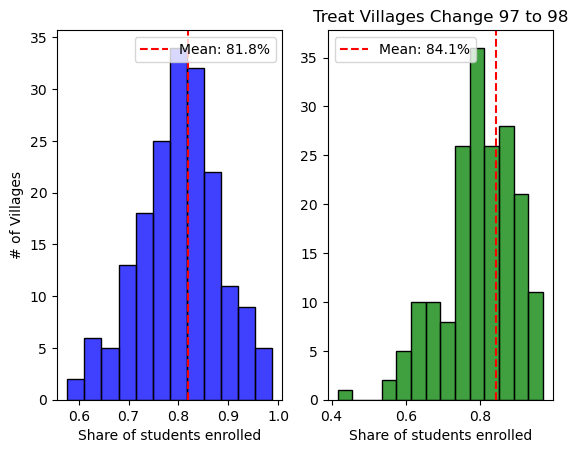

In [240]:
# Your code here

# - calculate avg rate of enrollment of poor hhs in treated villages in 1997
# - then again for 1998

df_enrollment_by_year = (
    df[df['progresa'] == 0]
    [['year','village', 'sc']]
    .value_counts()
    .unstack()
    .rename(columns = {0: 'not_enrolled', 1: 'enrolled'})
    .assign(enrolled_share = lambda dat: dat['enrolled']/(dat['enrolled'] + dat['not_enrolled']))
)

# plots
fig, ax = plt.subplots(1,2)

mean_enroll_97 = np.nanmean(df.query('progresa == 1 & year == 97')['sc'])
mean_enroll_98 = np.nanmean(df.query('progresa == 1 & year == 98')['sc']) 

sns.histplot(df_enrollment_by_year.loc[97,:]['enrolled_share'], color='blue', ax=ax[0])
sns.histplot(df_enrollment_by_year.loc[98,:]['enrolled_share'], color='green', ax=ax[1])

ax[0].axvline(x = mean_enroll_97, color='red', linestyle='--', label=f'Mean: {mean_enroll_97*100:.1f}%')
ax[1].axvline(x = mean_enroll_98, color='red', linestyle='--', label=f'Mean: {mean_enroll_98*100:.1f}%')


plt.title('Treat Villages Change 97 to 98')
ax[0].set_ylabel('# of Villages')
ax[1].set_ylabel(None)
ax[0].set_xlabel('Share of students enrolled')
ax[1].set_xlabel('Share of students enrolled')

ax[0].legend()
ax[1].legend()
plt.show()

In [241]:
# T-test for significance of difference
treat_97 = df.query('progresa == 1 & year == 97').set_index('folnum')
treat_98 = df.query('progresa == 1 & year == 98').set_index('folnum')

#treat_97.join(treat_98)

# Let's join the two together on folnum to make sure everyone lines up. Seems like there's nothing missing, even when there are NaNs
treat_diffs = pd.merge(treat_97, treat_98, on = 'folnum', suffixes = ['_97', '_98'])[['village_97','sc_97','sc_98']]

from scipy import stats
# We then want to use `ttest_rel` here since its same sample at different times
t_stat, p_val = stats.ttest_rel(treat_diffs['sc_97'], treat_diffs['sc_98'], nan_policy='omit')

print(f"t-stat: {t_stat:.5f}\np-value: {p_val:.5f}")

t-stat: 12.78869
p-value: 0.00000


*Discuss your results here*

Yes, there looks to be a difference of about `2.7%` between the two samples and that difference appears to be significant at almost any reasonable $\alpha$ level. Interestingly though, there appears to be a larger spread in the 1998 data than in the 1997 data - with more villages on the lower end of the spectrum than before. However, this does not show up when only comparing the means of the two samples.

### 1.5 Graphical exploration, part 2

Repeat the above exercise for poor households in **control villages**, before and after treatment. Do you observe a difference in enrollment in control villages between 1997 and 1998? How does what you observe here affect how you might approach measuring the impact of PROGRESA?

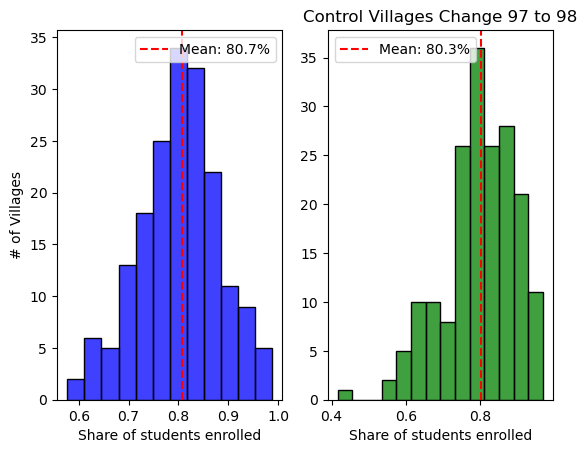

In [242]:
# Your code here
# Control Class

df_enrollment_by_year = (
    df[df['progresa'] == 0]
    [['year','village', 'sc']]
    .value_counts()
    .unstack()
    .rename(columns = {0: 'not_enrolled', 1: 'enrolled'})
    .assign(enrolled_share = lambda dat: dat['enrolled']/(dat['enrolled'] + dat['not_enrolled']))
)

# plots
fig, ax = plt.subplots(1,2)

mean_enroll_97 = np.nanmean(df.query('progresa == 0 & year == 97')['sc'])
mean_enroll_98 = np.nanmean(df.query('progresa == 0 & year == 98')['sc'])

sns.histplot(df_enrollment_by_year.loc[97,:]['enrolled_share'], color='blue', ax=ax[0])
sns.histplot(df_enrollment_by_year.loc[98,:]['enrolled_share'], color='green', ax=ax[1])

ax[0].axvline(x = mean_enroll_97, color='red', linestyle='--', label=f'Mean: {mean_enroll_97*100:.1f}%')
ax[1].axvline(x = mean_enroll_98, color='red', linestyle='--', label=f'Mean: {mean_enroll_98*100:.1f}%')

plt.title('Control Villages Change 97 to 98')
ax[0].set_ylabel('# of Villages')
ax[1].set_ylabel(None)
ax[0].set_xlabel('Share of students enrolled')
ax[1].set_xlabel('Share of students enrolled')

ax[0].legend()
ax[1].legend()
plt.show()

In [265]:
control_97 = df.query('progresa == 0 & year == 97').set_index('folnum')
control_98 = df.query('progresa == 0 & year == 98').set_index('folnum')


# Let's join the two together on folnum to make sure everyone lines up. Seems like there's nothing missing, even when there are NaNs
control_diffs = pd.merge(control_97, control_98, on = 'folnum', suffixes = ['_97', '_98'])[['village_97','sc_97','sc_98']]

from scipy import stats
# We then want to use `ttest_rel` here since its same sample at different times
t_stat, p_val = stats.ttest_rel(control_diffs['sc_97'], control_diffs['sc_98'], nan_policy='omit')

print(f"t-stat: {t_stat:.5f}\np-value: {p_val:.5f}")

t-stat: 19.57421
p-value: 0.00000


*Discuss your results here*

Whereas before there was a large difference in the two means, that doesn't appear to be the case here at all. In fact, the average enrollment actually went down. This difference does not appear to be significant at any reasonable $\alpha$ level. Therefore we can reasonably assume it is just due to random chance.

As for what this means for how we approach measuring the treatment effect overall, we should still most likely use a difference-of-differences approach, paritcularly because of the differences between the samples noted above. However, we can see a lot of the difference just in the top-line results


## Part 2: Measuring Impact

Our goal is to estimate the causal impact of the PROGRESA program on the social and economic outcomes of individuals in Mexico. We will focus on the impact of the program on school enrollment rates among the poor (those with poor=='pobre'), since only the poor were eligible to receive PROGRESA assistance, and since a primary objective of the program was to increase school enrollment.

### 2.1 Simple differences: T-test

Begin by estimating the impact of Progresa using "simple differences." Restricting yourself to data from 1998 (after treatment), calculate the average enrollment rate among **poor** households in the Treatment villages and the average enrollment rate among **poor** households in the control villages. Use a t-test to determine if this difference is statistically significant. What do you conclude?

In [244]:
# Your code here
df_enroll98_by_tc = (
    df
    .query('poor == 1')
    .query('year == 98')
    [['progresa', 'sc']]
    .value_counts()
    .unstack() # pivot
    .rename(columns = {0: 'not_enrolled', 1: 'enrolled'})
    .assign(
        enrolled_share = lambda dat: dat['enrolled']/(dat['enrolled'] + dat['not_enrolled'])
    )  
)

display(df_enroll98_by_tc)

df_poor98 = df.query('poor == 1 & year == 98')
t_stat, p_val = stats.ttest_ind(df_poor98[df_poor98['progresa'] == 1]['sc'], df_poor98[df_poor98['progresa'] == 0]['sc'], nan_policy='omit')
print(f"t-stat: {t_stat:.5f}\np-value: {p_val:.5f}")

sc,not_enrolled,enrolled,enrolled_share
progresa,,,
0,2005,8418,0.807637
1,2614,14413,0.846479


t-stat: 8.35872
p-value: 0.00000


### 2.2 Simple differences: Regression

Estimate the effects of Progresa on enrollment using a regression model, by regressing the 1998 enrollment rates **of the poor** on treatment assignment. For now, do not include any other variables in your regression. Discuss the following:

* Based on this model, how much did Progresa increase or decrease the likelihood of a child enrolling? Make sure you express you answer in a sentence that a person with no technical background could understand, using appropriate units.
* How does your regression estimate compare to your t-test estimate from part 2.1?
* Based on this regression model, can we reject the null hypothesis that the treatment effects are zero? 
* What is the counterfactual assumption underlying this regression?

*Discuss your results here*

The difference appears to be significant at any reasonable significance level (< .000005). This alone cannot tell us the effect of the treatment, but it does suggest there was either a big effect of the treatment, a big difference between the two groups receiving treatment or something else unexpected happened.


In [259]:
# Your code here
from sklearn.linear_model import LinearRegression
import numpy as numpy
import matplotlib.pyplot as plt

# For now, do not include any other variables in your regression

# Note: we were told to do so at the individual level only

# Define Vars
iv = 'progresa'
dv = 'sc'

# Look at nulls
dat_ = df_poor98.loc[df_poor98[dv].dropna().index]
dat_[[dv, iv]].isna().any() # looks like they are all null in the same place

# Define Variables
Y = dat_[dv]
X = dat_[iv]
X = sm.add_constant(X)

model = sm.OLS(Y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     sc   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     69.87
Date:                Tue, 06 Feb 2024   Prob (F-statistic):           6.64e-17
Time:                        23:19:02   Log-Likelihood:                -11926.
No. Observations:               27450   AIC:                         2.386e+04
Df Residuals:                   27448   BIC:                         2.387e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8076      0.004    220.676      0.000       0.800       0.815
progresa       0.0388      0.005      8.359      0.000       0.030       0.048
==============================================================================
Omnibus:                     7638.939   Durbin-Watson:                   1.734
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            15767.534
Skew:                          -1.767   Prob(JB):                         0.00
Kurtosis:                       4.140   Cond. No.                         3.01
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

*Discuss your results here*

Accoridng to the (fairly simplistic) model above, a village being a part of the `progresa` program is associated with about a 3.88% positive impact on enrollment rate of a student in that village with a fairly high level of certainty that there is at least some positive impact (95% CI: 3% - 4.8%).

This differs a bit from the t-statistic above because it attempts to measure the magnitude of the difference, not solely whether there exists one. The `t-test` operates with a null Hypothesis that the is no difference between the means of the two groups, whereas the regression `H0` is that there is no *relationship* between the treatment variable and the outcome. These different questions and the different assumptions involved in them lead to different results for what is fundamentally a similar test.

Based on this regression, we could likely reject the null hypothesis that the treatment had no effect - *however* this does not account for many potential confounding variables and differences between the two groups that aren't captured by these narrow statistical measures. As such, I wouldn't be as sure immediately that the effect is actually as much a result of the treatment as the above summary might suggest.

The counterfactual assumption is that there is no relationship between enrollment rates in a village and whether or not that village was part of the progresa treatment program - however, it does not assert causation.


### 2.3 Multiple Regression

Estimate the above regression, but this time include a set of control variables. Include, for instance, age, distance to a secondary school, gender, education of household head, welfare index, indigenous, etc.

* How do the controls affect the point estimate of treatment effect?
* How do the controls affect the standard error on the treatment effect? 
* How do you interpret the differences (or similarities) between your estimates of 2.2 and 2.3?
* Interpet the coefficient associated with the `dist_sec` variable. Is this evidence that the household's distance from a secondary school has a *causal* impact on educational attainment?

Based on the t-test in `part 1.1`, we can see there are significant differences in the population means of the two groups on a number of variables. Given this, these variables are possibly good candidates to use as controls.

In [266]:
alpha = .05
controls_list = df97_t_summary_df[df97_t_summary_df['p_val'] < .05].index.tolist()
print(controls_list)

# Define Vars
iv = 'progresa'
dv = 'sc'

# Deal with Nulls
df_poor98[df_poor98[dv].isnull()]

## Need to check correct null rates first:
(
    df[['poor', 'year', 'sc']]
    .value_counts(dropna=False)
    .unstack()
    .rename(columns={0: 'not_enroll', 1: 'enroll'})
    .assign(
        enrolled_share = lambda dat: dat['enroll']/(dat['enroll'] + dat['not_enroll']),
        null_share = lambda dat: dat[np.nan]/(dat['enroll'] + dat['not_enroll'] + dat[np.nan])
    )
    .pipe(display)
)
# For poor, 98, we should have 22831 enrollees, 4619 unenrolled, and 5246 nulls

# Ok, remove those with null in the dv and define data
dat_ = df_poor98.loc[df_poor98[dv].dropna().index]
dat_[[dv, iv] + controls_list].isna().any() # looks like only `hohag`, `sex` and `welfare_index` have nulls
dat_[[dv, iv] + controls_list].isna().sum() # and its only like 73 max, let's just drop them all

# Define data
Y = dat_[[dv, iv] + controls_list].dropna()[dv]
X = dat_[[dv, iv] + controls_list].dropna()[[iv] + controls_list]
X = sm.add_constant(X)

# Build Model
import statsmodels.api as sm
model = sm.OLS(Y, X).fit()

display(model.summary())



['dist_cap', 'dist_sec', 'hohage', 'hohedu', 'hohwag', 'min_dist', 'sex', 'welfare_index']


sc         not_enroll  enroll   NaN  enrolled_share  null_share
poor year                                                      
0    97          1256    4511   162        0.782209    0.027323
     98           950    3708  1271        0.796050    0.214370
1    97          5571   25351  1774        0.819837    0.054257
     98          4619   22831  5246        0.831730    0.160448

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     sc   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     100.4
Date:                Tue, 06 Feb 2024   Prob (F-statistic):          1.52e-185
Time:                        23:37:27   Log-Likelihood:                -11451.
No. Observations:               27363   AIC:                         2.292e+04
Df Residuals:                   27353   BIC:                         2.300e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.8823      0.017     52.065      0.000       0.849       0.916
progresa          0.0337      0.005      7.318      0.000       0.025       0.043
dist_cap          0.0002   3.96e-05      6.025      0.000       0.000       0.000
dist_sec         -0.0096      0.001     -9.474      0.000      -0.012      -0.008
hohage           -0.0025      0.000    -11.197      0.000      -0.003      -0.002
hohedu            0.0111      0.001     11.283      0.000       0.009       0.013
hohwag        -2.228e-06   3.23e-06     -0.691      0.490   -8.55e-06    4.09e-06
min_dist          0.0004   7.29e-05      5.421      0.000       0.000       0.001
sex               0.0249      0.004      5.599      0.000       0.016       0.034
welfare_index -9.279e-05   2.02e-05     -4.592      0.000      -0.000   -5.32e-05
==============================================================================
Omnibus:                     7183.545   Durbin-Watson:                   1.761
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            14286.818
Skew:                          -1.688   Prob(JB):                         0.00
Kurtosis:                       4.068   Cond. No.                     7.87e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.87e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

*Discuss your results here*

According to the linear regression above, basically all variables included had a significant impact on the enrollment rates of students, except `hohwag`. However, from the regression, we can see a measured effect of `+.0337` for the `progresa` treatment itself (with a p-value below .0005), suggesting that there is a significant, positive relationship between the treatment and enrollment rates. In fact, this says that, on whole, for a generic student, controlling for other demographic factors, if their village were included in the `progresa` program, they might see a `.0337` increase in their enrollment (in aggregate, since enrollment is actually binary) compared to a student whose village was not included.

* How do the controls affect the point estimate of treatment effect?

    *The controls actually don't have much effect on the overall estimate, they move it from `+.3.88%` change to a `+3.37%` change, a difference of about `.5%`.
    
* How do the controls affect the standard error on the treatment effect? 
    
    *The controls seem to not change the standard error much at all, staying at a similar `.005`*

* How do you interpret the differences (or similarities) between your estimates of 2.2 and 2.3?

    *I would interpret these differences as essentially saying a small, but non-negligible, portion of the change attributed to the treatment in 2.2 can be actually explained by variation in other demographic factors between the two groups. However, that portion is not enough that adjusting for the other terms makes much of a difference in our accuracy (or error rate) in measuring the effect of the treatment. This could either be true or mean that we are maybe missing some key factors on which to control (or not using a sophisticated enough approach)*
    
* Interpet the coefficient associated with the `dist_sec` variable. Is this evidence that the household's distance from a secondary school has a *causal* impact on educational attainment?

    *the coefficient for the `dist_sec` variable is measured here as `-0.0096`, which implies that as the distance a village or individual is from a secondary school increases, those students' rate of enrollment goes down (in aggregate). This shows a strong, and significant, relationship between these variables but does not imply causation because the regression and the experiment is not set up in a manner to test for the causal effect of `dist_sec`, as it is set up to do so for `progresa`.

### 2.4 Multiple Regression Revisited

For the same set of control variables that you used in 2.3, carry out the following alternative estimation procedure. 

* First, regress the 1998 enrollment of the poor on the control variables, **without including the treatment assignment.** 
* Second, use this model to obtain predicted values of the 1998 enrollment for each child in the sample used to estimate the model in step 1. 
* Third, compute a new value for each child, which is the difference between the actual 1998 enrollment and the predicted enrollment value from step 2. 
* Finally, regress the difference from step 3 on treatment assignment.

Compare the point estimate and the standard error on treatment assignment that you obtained in step 4 to their analogues in 2.3. Explain the results.

In [267]:
# Your code here
# 1) regress without including the treatment assignment
X_no_treat = X.drop(iv, axis = 1)
X_no_treat = sm.add_constant(X_no_treat)
model_no_treat = sm.OLS(Y, X_no_treat).fit()
display(model_no_treat.summary())
#X.drop(iv, axis = 1)

# 2) obtain predicted values for each child
pred_no_treat = model_no_treat.predict(X_no_treat)

# 3) compute difference between actual enrollment and predicted enrollment
err = (Y - pred_no_treat)

# 4) regress on the difference from step 3 on treatment assignment
model_err_by_tc = sm.OLS(err, sm.add_constant(X[iv])).fit() # note: 'tc' = treatment-control var
model_err_by_tc.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     sc   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     106.0
Date:                Tue, 06 Feb 2024   Prob (F-statistic):          4.77e-175
Time:                        23:37:30   Log-Likelihood:                -11478.
No. Observations:               27363   AIC:                         2.297e+04
Df Residuals:                   27354   BIC:                         2.305e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.9051      0.017     54.286      0.000       0.872       0.938
dist_cap          0.0002   3.95e-05      5.532      0.000       0.000       0.000
dist_sec         -0.0097      0.001     -9.587      0.000      -0.012      -0.008
hohage           -0.0025      0.000    -11.342      0.000      -0.003      -0.002
hohedu            0.0112      0.001     11.358      0.000       0.009       0.013
hohwag        -3.123e-06   3.23e-06     -0.968      0.333   -9.45e-06     3.2e-06
min_dist          0.0004   7.27e-05      6.055      0.000       0.000       0.001
sex               0.0253      0.004      5.670      0.000       0.017       0.034
welfare_index -9.541e-05   2.02e-05     -4.718      0.000      -0.000   -5.58e-05
==============================================================================
Omnibus:                     7212.906   Durbin-Watson:                   1.758
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            14381.701
Skew:                          -1.693   Prob(JB):                         0.00
Kurtosis:                       4.073   Cond. No.                     7.73e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.73e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     53.05
Date:                Tue, 06 Feb 2024   Prob (F-statistic):           3.34e-13
Time:                        23:37:30   Log-Likelihood:                -11451.
No. Observations:               27363   AIC:                         2.291e+04
Df Residuals:                   27361   BIC:                         2.292e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0208      0.004     -5.743      0.000      -0.028      -0.014
progresa       0.0334      0.005      7.283      0.000       0.024       0.042
==============================================================================
Omnibus:                     7175.622   Durbin-Watson:                   1.761
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            14261.280
Skew:                          -1.686   Prob(JB):                         0.00
Kurtosis:                       4.066   Cond. No.                         3.01
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

*Discuss your results here*
The above, two-step regressions show an effect of `+3.34%` for the treatment variable on enrollment. Despite this being a pretty different . This is actually pretty similar to the `+3.37%` effect measured above.

### 2.5 Difference-in-Difference, version 1 (tabular)

Thus far, we have computed the effects of Progresa by estimating the difference in 1998 enrollment rates across villages. An alternative approach would be to compute the treatment effect using a difference-in-differences framework.

Begin by estimating the average treatment effects of the program for poor households using data from 1997 and 1998. Specifically, calculate the difference (between 1997 and 1998) in enrollment rates among poor households in treated villages; then compute the difference (between 1997 and 1998) in enrollment rates among poor households in control villages. 

Display your results in a 2x2 table where the rows are Control/Treatment and the columns are 1997/1998. 

* What is your difference-in-difference estimate of the impact, and how does it compare to your earlier (simple difference) results?
* What is the counterfactual assumption underlying this estimate? 


In [315]:
# Your code here

# - difference betw. 97 and 98 in enrollment rates among poo
df__ = (
     df
    .query('poor == 1')
    .groupby(['progresa', 'year'])
    .mean()
    [['sc']]
    .unstack()
    .rename(index={0: 'Control', 1: 'Treat'})
)

# Fix names (idk how to do this in a chain :/)
df__.columns = df__.columns.droplevel(0)
df__.index.name = None

# print
(
    df__
    .rename(columns ={97: '1997', 98: '1998'})
    .style
        .format('{:.1%}')
        .background_gradient()
    .pipe(display)
)

# Note: we should probably do this by only including people who exist in both samples (exclude any nulls in both)
print(f'DiD effect: {(.846 - .823) - (.808 - .815)}')

year,1997,1998
Control,81.5%,80.8%
Treat,82.3%,84.6%


DiD effect: 0.029999999999999916


*Discuss your results here*

Here we see the difference between enrollment rates in each year. We see that the overall enrollment rate among the treatment group increased from `82.3%` to `84.6%`, while the 

* What is your difference-in-difference estimate of the impact, and how does it compare to your earlier (simple difference) results?

Given the rates above, we'd calculate the difference-in-difference estimate of impact as `(84.6% - 82.3%) - (80.8% - 81.5%)` = `+3%`.

* What is the counterfactual assumption underlying this estimate

The counterfactual assumption is the counterfactual assumption underlying any difference-in-difference estimate: that if the treatment had not been enacted, the treatment and control groups would have continued on similar trends: i.e. both would have gone down `~.7%`.



### 2.6 Difference-in-Difference, version 2 (regression)

Now use a regression specification to estimate the average treatment effects of the program in a difference-in-differences, for the poor households. Do this (i) first without including any control variables; and then (ii) do it a second time including at least 5 control variables. 

* What is your estimate (i) of the impact of Progresa? Be very specific in interpreting your coefficients and standard errors, and make sure to specify exactly what units you are measuring and estimating.
* Does your estimate of the impact of Progresa from (i) change when you add control variables as in (ii)? How do you explain these changes, or the lack of changes on the `progresa` coefficient between (i) and (ii)?
* How do the estimates from (i) and (ii) compare to the difference-in-difference estimates from 2.4 above? What accounts for these differences, if any exist?
* What is the counterfactual assumption underlying regression (ii)? 

In [309]:
# Your code here

# i. No control variables
df_poor = df[df['poor'] == 1] # <- finally just create this

# from slides Regression eq: Yi = a + BTi + yPOSTi + d(Ti*POSTi) + e
df_poor[['progresa']]

# Let's define each term in a table - note `i` here is for 'part i' not an index.
df_i = df_poor[['sc', 'progresa', 'year']]
df_i = df_i.rename(columns={'sc': 'Y', 'progresa': 'Treatment', 'year': 'Time'})
df_i['Time'] = df_i['Time'] - 97 # turn it into binary 98 = 1, 97 = 0
df_i['Interaction'] = df_i['Treatment'] * df_i['Time']

df_i.isna().any() # has nulls but only in Y
df_i = df_i.dropna() # drop em

df_i.head(5).pipe(display)

# Define Regression
Y_i = df_i['Y']
X_i = sm.add_constant(df_i.drop('Y', axis = 1))

# Model i
model_i = sm.OLS(Y_i, X_i).fit()
display(model_i.summary())

# ii. Now with the same controls as above
df_poor[controls_list]

# Define terms
df_ii = df_poor[['sc', 'progresa', 'year'] + controls_list]
df_ii = df_ii.rename(columns={'sc': 'Y', 'progresa': 'Treatment', 'year': 'Time'})
df_ii['Time'] = df_ii['Time'] - 97 # turn it into binary 98 = 1, 97 = 0
df_ii['Interaction'] = df_ii['Treatment'] * df_ii['Time']

df_ii.isna().any() # Y, hohage, sex and welfare_index have nulls
df_ii = df_ii.dropna()

display(df_ii.head(5))

# Define Regression
Y_ii = df_ii['Y']
X_ii = sm.add_constant(df_ii.drop('Y', axis = 1))

# Model ii
model_ii = sm.OLS(Y_ii, X_ii).fit()
display(model_ii.summary())

,Y,Treatment,Time,Interaction
0,1.0,0,0,0
1,1.0,0,1,0
2,1.0,0,0,0
3,1.0,0,1,0
4,1.0,0,0,0


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     28.31
Date:                Wed, 07 Feb 2024   Prob (F-statistic):           2.76e-18
Time:                        00:25:51   Log-Likelihood:                -26242.
No. Observations:               58372   AIC:                         5.249e+04
Df Residuals:                   58368   BIC:                         5.253e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.8152      0.003    233.182      0.000       0.808       0.822
Treatment       0.0075      0.004      1.691      0.091      -0.001       0.016
Time           -0.0075      0.005     -1.480      0.139      -0.018       0.002
Interaction     0.0313      0.006      4.835      0.000       0.019       0.044
==============================================================================
Omnibus:                    15346.988   Durbin-Watson:                   1.397
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            30608.651
Skew:                          -1.711   Prob(JB):                         0.00
Kurtosis:                       3.937   Cond. No.                         7.67
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

,Y,Treatment,Time,dist_cap,dist_sec,hohage,hohedu,hohwag,min_dist,sex,welfare_index,Interaction
0,1.0,0,0,21.168384,4.473,35.0,6,0.0,21.168384,0.0,583.0,0
1,1.0,0,1,21.168384,4.473,35.0,6,0.0,21.168384,0.0,583.0,0
2,1.0,0,0,21.168384,4.473,35.0,6,0.0,21.168384,1.0,583.0,0
3,1.0,0,1,21.168384,4.473,35.0,6,0.0,21.168384,1.0,583.0,0
4,1.0,0,0,21.168384,4.473,35.0,6,0.0,21.168384,0.0,583.0,0


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     158.1
Date:                Wed, 07 Feb 2024   Prob (F-statistic):               0.00
Time:                        00:25:51   Log-Likelihood:                -25314.
No. Observations:               58192   AIC:                         5.065e+04
Df Residuals:                   58180   BIC:                         5.076e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.9007      0.012     74.419      0.000       0.877       0.924
Treatment         0.0032      0.004      0.724      0.469      -0.005       0.012
Time             -0.0080      0.005     -1.580      0.114      -0.018       0.002
dist_cap          0.0002   2.76e-05      8.413      0.000       0.000       0.000
dist_sec         -0.0086      0.001    -11.866      0.000      -0.010      -0.007
hohage           -0.0023      0.000    -15.218      0.000      -0.003      -0.002
hohedu            0.0111      0.001     16.160      0.000       0.010       0.012
hohwag        -1.157e-07   2.23e-06     -0.052      0.959   -4.49e-06    4.26e-06
min_dist          0.0004    5.1e-05      7.448      0.000       0.000       0.000
sex               0.0287      0.003      9.267      0.000       0.023       0.035
welfare_index    -0.0001   1.41e-05     -8.671      0.000      -0.000   -9.44e-05
Interaction       0.0306      0.006      4.778      0.000       0.018       0.043
==============================================================================
Omnibus:                    14454.907   Durbin-Watson:                   1.422
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            27853.355
Skew:                          -1.637   Prob(JB):                         0.00
Kurtosis:                       3.874   Cond. No.                     8.23e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.23e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

*Discuss your results here*

Here we see the effects of a very simple DiD regression analysis without controls. In this 
* What is your estimate (i) of the impact of Progresa? Be very specific in interpreting your coefficients and standard errors, and make sure to specify exactly what units you are measuring and estimating.

    *In part i, the impact of the estimate of Progresa is the coefficient of the `interaction` term which is `+3.13%`, with a std.error of `0.6%` which is significant at any reasonable confidence level. This implies that the treatment would have an effect of increasing enrollment (in aggregate) by `3.13%` compared to a counterfactual where they did not receive treatment*

* Does your estimate of the impact of Progresa from (i) change when you add control variables as in (ii)? How do you explain these changes, or the lack of changes on the `progresa` coefficient between (i) and (ii)?

    *In part ii, the estimate for the impact of progresa over time (the `interaction` term), goes down slightly to `+3.06%` while the error and p-value remain essentially unchanged. These lack of changes seem to be largely the result of very small coefficients on the other terms? Many of the control terms are very significant but have very small magnitudes. The model also appears to have compensated by increasing the magnitude of the intercept term significantly. This makes me concerned a bit about colinearity between all of the terms but I'm not sure we've learned enough to estimate the exact issue here.*

* How do the estimates from (i) and (ii) compare to the difference-in-difference estimates from 2.4 above? What accounts for these differences, if any exist?

    *These differences are, somewhat surprisingly, not very different from the estimate in 2.4, which was just about `+3%`. This can maybe be attributed to a treatment effect that works fairly well on all demographic groups?*
    
* What is the counterfactual assumption underlying regression (ii)? 
    *The counterfactual underlying regression ii, is that, in the absence of the treatment intervention, enrollment among those in the treatment group would have fluctuated similarly to how it did among those in the control group i.e. it would be affected by the coefficients on other variables including `Time`*


### 2.7 Spillover effects

Thus far, we have focused on the impact of PROGRESA on the school enrollment of poor households. Repeat your analysis in 2.5, instead focusing on (a) the impact of PROGRESA on the school enrollment of non-poor households, and (b) the impact ofo PROGRESA on *other outcomes* of poor households that might plausibly have been affected by the PROGRESA program.
* Do you observe any impacts of PROGRESA on the school enrollment of the non-poor?
* Regardless of whether you find evidence of spillovers to non-poor, describe one or two reasons why PROGRESA *might* have impacted non-poor households. Give concrete examples based on the context in which PROGRESA was implemented.
* Do you observe any impacts of PROGRESA on other aspects of the welfare of poor households? 

In [316]:
# Your code here
df_nonpoor = df[df['poor'] == 0]
df_nonpoor_DiD = (
    df_nonpoor
    .groupby(['progresa', 'year'])
    .mean()
    [['sc']]
    .unstack()
    .rename(index={0: 'Control', 1: 'Treat'})
)

df_nonpoor_DiD.columns = df_nonpoor_DiD.columns.droplevel(0)
df_nonpoor_DiD.index.name = None
df_nonpoor_DiD['diff'] = df_nonpoor_DiD[98] - df_nonpoor_DiD[97]

# print
print('Effect among non-poor households')
(
    df_nonpoor_DiD
    .rename(columns ={97: '1997', 98: '1998'})
    .style
        .format('{:.1%}')
        .background_gradient()
    .pipe(display)
)

effect 


year,1997,1998,diff
Control,76.3%,77.6%,1.4%
Treat,79.5%,80.9%,1.4%


*Discuss your results here*
* Do you observe any impacts of PROGRESA on the school enrollment of the non-poor?

    *From this basic DiD top-line test, this seems to show there is essentially no difference between groups of non-poor students in villages without treatment and those with treatment. This could change with a more robust analysis of the data, but this is a good piece of evidence that it may be hard to reject that null hypothesis.*

* Regardless of whether you find evidence of spillovers to non-poor, describe one or two reasons why PROGRESA *might* have impacted non-poor households. Give concrete examples based on the context in which PROGRESA was implemented.

    **

* Do you observe any impacts of PROGRESA on other aspects of the welfare of poor households? 

### 2.8 Summary

* Based on all the analysis you have undertaken to date, do you believe that Progresa had a causal impact on the enrollment rates of poor households in Mexico? 

*Discuss your results here*
Based on all the above measures, I do believe the 